In [2]:
import os
import pandas as pd 
import numpy as np
import datetime as dt 
import math
import tensorflow as tf
from sklearn.metrics import confusion_matrix, mean_squared_error, mean_absolute_error, r2_score, explained_variance_score, mean_poisson_deviance, mean_gamma_deviance, accuracy_score 
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Input, GRU, Dropout, Dense,LSTM, Attention,Bidirectional,MultiHeadAttention,Attention, BatchNormalization
from tensorflow.keras.optimizers import Adam
import tensorflow.keras
import matplotlib.pyplot as plt 
from itertools import cycle
import plotly.graph_objects as go
import plotly.express as xp
import plotly.subplots as sp
tf.test.gpu_device_name()
import yfinance as yf
goog = yf.Ticker("GOOG")
goog_df = goog.history(period="max")
goog_df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2004-08-19 00:00:00-04:00,2.490664,2.591785,2.390042,2.499133,897427216,0.0,0.0
2004-08-20 00:00:00-04:00,2.515820,2.716817,2.503118,2.697639,458857488,0.0,0.0
2004-08-23 00:00:00-04:00,2.758411,2.826406,2.716070,2.724787,366857939,0.0,0.0
2004-08-24 00:00:00-04:00,2.770615,2.779581,2.579581,2.611960,306396159,0.0,0.0
2004-08-25 00:00:00-04:00,2.614201,2.689918,2.587302,2.640104,184645512,0.0,0.0


In [3]:
goog_df.reset_index(inplace=True)

In [4]:
pred_open=goog_df[['Date','Open']]
pred_open

,Date,Open
0,2004-08-19 00:00:00-04:00,2.490664
1,2004-08-20 00:00:00-04:00,2.515820
2,2004-08-23 00:00:00-04:00,2.758411
3,2004-08-24 00:00:00-04:00,2.770615
4,2004-08-25 00:00:00-04:00,2.614201
...,...,...
4851,2023-11-27 00:00:00-05:00,137.570007
4852,2023-11-28 00:00:00-05:00,137.630005
4853,2023-11-29 00:00:00-05:00,138.985001
4854,2023-11-30 00:00:00-05:00,136.399994


In [5]:
goo=goog_df['Open']
goo

0         2.490664
1         2.515820
2         2.758411
3         2.770615
4         2.614201
           ...    
4851    137.570007
4852    137.630005
4853    138.985001
4854    136.399994
4855    133.320007
Name: Open, Length: 4856, dtype: float64

In [6]:

#Normalizing
scalar=MinMaxScaler(feature_range=(0,1))
goo=scalar.fit_transform(np.array(goo).reshape(-1,1))
goo.shape
#split train and test data
split_size_train_val=0.8
split_size_val_test=0.1
time_step=15
train,val,test=goo[0:int(len(goo)*split_size_train_val),:], goo[int(len(goo)*split_size_train_val):int(len(goo)*split_size_train_val)+int(len(goo)*split_size_val_test),:],goo[int(len(goo)*split_size_train_val)+int(len(goo)*split_size_val_test):,:]
print(train.shape,val.shape,test.shape)
#transform to time-series-like data


(3884, 1) (485, 1) (487, 1)


In [7]:
def time_series(goog_df,time_stemp):
    X=[]
    y=[]
    for i in range(len(goog_df)-time_step-1):
        a=goog_df[i:(i+time_stemp),0]
        X.append(a)
        y.append(goog_df[i+time_stemp])
    return np.array(X),np.array(y)
trainX,train_y=time_series(train,time_step)
valX,val_y=time_series(val,time_step)
testX,test_y=time_series(test,time_step)

print(trainX.shape,train_y.shape)
print(valX.shape,val_y.shape)
print(testX.shape,test_y.shape)

# reshape input to be [samples, time steps, features] which is required for LSTM
trainX =trainX.reshape(trainX.shape[0],trainX.shape[1] , 1)
valX = valX.reshape(valX.shape[0],valX.shape[1] , 1)
testX = testX.reshape(testX.shape[0],testX.shape[1] , 1)

print("X_train: ", trainX.shape)
print("X_Val: ", valX.shape)
print("X_test: ", testX.shape)

(3868, 15) (3868, 1)
(469, 15) (469, 1)
(471, 15) (471, 1)
X_train:  (3868, 15, 1)
X_Val:  (469, 15, 1)
X_test:  (471, 15, 1)


In [8]:
from attention import Attention
from keras.layers import Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense
m = Sequential()
m.add(LSTM(64, return_sequences=True, input_shape=(time_step,1)))
m.add(Bidirectional(LSTM(64, return_sequences=True)))
m.add(Attention(32))
m.add(Dense(1))
m.compile(optimizer='adam', loss='mse')
m.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 15, 64)            16896     
                                                                 
 bidirectional (Bidirectiona  (None, 15, 128)          66048     
 l)                                                              
                                                                 
 attention (Attention)       (None, 32)                24576     
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 107,553
Trainable params: 107,553
Non-trainable params: 0
_________________________________________________________________


In [9]:
callbacks = [tensorflow.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]
history=m.fit(trainX,train_y,
                  epochs=200,
                  validation_data=(valX,val_y),
                  verbose=1,
                  batch_size=32,
                  callbacks=callbacks
                 )

Epoch 1/200
121/121 [==============================] - 8s 24ms/step - loss: 8.4808e-04 - val_loss: 7.6725e-04
Epoch 2/200
121/121 [==============================] - 2s 15ms/step - loss: 5.1283e-05 - val_loss: 0.0010
Epoch 3/200
121/121 [==============================] - 2s 15ms/step - loss: 5.2493e-05 - val_loss: 0.0013
Epoch 4/200
121/121 [==============================] - 2s 16ms/step - loss: 4.8309e-05 - val_loss: 8.5325e-04
Epoch 5/200
121/121 [==============================] - 2s 16ms/step - loss: 5.0093e-05 - val_loss: 0.0015
Epoch 6/200
121/121 [==============================] - 2s 16ms/step - loss: 4.8374e-05 - val_loss: 6.7024e-04
Epoch 7/200
121/121 [==============================] - 2s 18ms/step - loss: 4.5819e-05 - val_loss: 8.1724e-04
Epoch 8/200
121/121 [==============================] - 2s 19ms/step - loss: 4.5842e-05 - val_loss: 9.1501e-04
Epoch 9/200
121/121 [==============================] - 2s 17ms/step - loss: 4.3220e-05 - val_loss: 7.4573e-04
Epoch 10/200
121/121 [

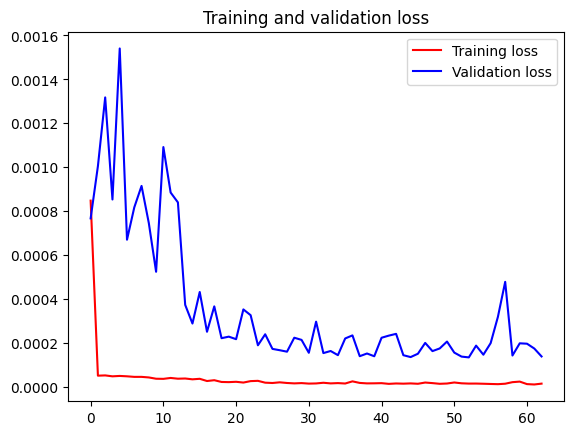

<Figure size 640x480 with 0 Axes>

In [10]:
#learning curves
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()

In [11]:
train_predict=m.predict(trainX)
val_predict=m.predict(valX)
test_predict=m.predict(testX)
train_predict.shape, val_predict.shape, test_predict.shape

15/15 [==============================] - 0s 6ms/step


((3868, 1), (469, 1), (471, 1))

In [12]:
# Transform back to original form
train_predict = scalar.inverse_transform(train_predict)
test_predict = scalar.inverse_transform(test_predict)
val_predict = scalar.inverse_transform(val_predict)
original_ytrain = scalar.inverse_transform(train_y.reshape(-1,1)) 
original_ytest = scalar.inverse_transform(test_y.reshape(-1,1))
original_yval = scalar.inverse_transform(val_y.reshape(-1,1))

In [13]:
look_back=time_step
trainPredictPlot = np.empty_like(goo)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)

Train predicted data:  (4856, 1)


In [14]:
valPredictPlot = np.empty_like(goo)
valPredictPlot[:, :] = np.nan
valPredictPlot[len(train_predict)+look_back:len(train_predict)+len(val_predict)+look_back, :] = val_predict
print("Validation predicted data: ", valPredictPlot.shape)


Validation predicted data:  (4856, 1)


In [15]:
testPredictPlot = np.empty_like(goo)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+len(val_predict)+look_back : len(train_predict)+len(val_predict)+len(test_predict)+look_back, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)

names = cycle(['Original open price','Train predicted open price','Validation predicted open price','Test predicted open price'])

Test predicted data:  (4856, 1)


In [16]:
plotdf = pd.DataFrame({'Date': pred_open['Date'],
                       'original_open': pred_open['Open'],
                      'train_predicted_open': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'val_predicted_open': valPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_open': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = xp.line(plotdf,x=plotdf['Date'], y=[plotdf['original_open'],plotdf['train_predicted_open'],plotdf['val_predicted_open'],
                                          plotdf['test_predicted_open']],
              labels={'value':'Stock price','date': 'Date'})

fig.update_layout(title_text='Comparision between original open price vs predicted open price',
                  plot_bgcolor='white', font_size=15, font_color='black', legend_title_text='Open Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

In [17]:
#Evaluation metrics for both test and validation data
print("Evaluation metrics for validation data: ")
print("Mean squared error: ", mean_squared_error(original_yval,val_predict))
print("Mean absolute error: ", mean_absolute_error(original_yval,val_predict))
# rmse
print("Root mean squared error: ", math.sqrt(mean_squared_error(original_yval,val_predict)))
print("R2 score: ", r2_score(original_yval,val_predict))
print("Explained variance score: ", explained_variance_score(original_yval,val_predict))
print("Mean poisson deviance: ", mean_poisson_deviance(original_yval,val_predict))
print("Mean gamma deviance: ", mean_gamma_deviance(original_yval,val_predict))
#print("Accuracy score: ", accuracy_score(original_yval,val_predict.round()))
print("\n")
print("Evaluation metrics for test data: ")
print("Mean squared error: ", mean_squared_error(original_ytest,test_predict))
print("Mean absolute error: ", mean_absolute_error(original_ytest,test_predict))
#rmse
print("Root mean squared error: ", math.sqrt(mean_squared_error(original_ytest,test_predict)))
print("R2 score: ", r2_score(original_ytest,test_predict))
print("Explained variance score: ", explained_variance_score(original_ytest,test_predict))
print("Mean poisson deviance: ", mean_poisson_deviance(original_ytest,test_predict))
print("Mean gamma deviance: ", mean_gamma_deviance(original_ytest,test_predict))
#print("Accuracy score: ", accuracy_score(original_ytest,test_predict.round()))


Evaluation metrics for validation data: 
Mean squared error:  3.0018537166308543
Mean absolute error:  1.2787736595820771
Root mean squared error:  1.7325858468286224
R2 score:  0.9965048018190404
Explained variance score:  0.9965321848252526
Mean poisson deviance:  0.03296759506230243
Mean gamma deviance:  0.0003961254595644961


Evaluation metrics for test data: 
Mean squared error:  6.312412561290905
Mean absolute error:  1.908882060121832
Root mean squared error:  2.5124515042664815
R2 score:  0.9754126115346247
Explained variance score:  0.9759210954076952
Mean poisson deviance:  0.05394732572176219
Mean gamma deviance:  0.0004703804399255306


In [18]:
#save the pyplot in html
import plotly.io as pio
pio.write_html(fig, file='result.html', auto_open=True)


In [67]:

#Normalizing
scalar=MinMaxScaler(feature_range=(0,1))
goo=scalar.fit_transform(np.array(goo).reshape(-1,1))
goo.shape
#split train and test data
split_size_train_val=0.8
split_size_val_test=0.1
time_step=15
train,val,test=goo[0:int(len(goo)*split_size_train_val),:], goo[int(len(goo)*split_size_train_val):int(len(goo)*split_size_train_val)+int(len(goo)*split_size_val_test),:],goo[int(len(goo)*split_size_train_val)+int(len(goo)*split_size_val_test):,:]
print(train.shape,val.shape,test.shape)
#transform to time-series-like data


(3880, 1) (485, 1) (485, 1)


In [68]:
def time_series(goog_df,time_stemp):
    X=[]
    y=[]
    for i in range(len(goog_df)-time_step-1):
        a=goog_df[i:(i+time_stemp),0]
        X.append(a)
        y.append(goog_df[i+time_stemp])
    return np.array(X),np.array(y)
trainX,train_y=time_series(train,time_step)
valX,val_y=time_series(val,time_step)
testX,test_y=time_series(test,time_step)

print(trainX.shape,train_y.shape)
print(valX.shape,val_y.shape)
print(testX.shape,test_y.shape)

# reshape input to be [samples, time steps, features] which is required for LSTM
trainX =trainX.reshape(trainX.shape[0],trainX.shape[1] , 1)
valX = valX.reshape(valX.shape[0],valX.shape[1] , 1)
testX = testX.reshape(testX.shape[0],testX.shape[1] , 1)

print("X_train: ", trainX.shape)
print("X_Val: ", valX.shape)
print("X_test: ", testX.shape)

(3864, 15) (3864, 1)
(469, 15) (469, 1)
(469, 15) (469, 1)
X_train:  (3864, 15, 1)
X_Val:  (469, 15, 1)
X_test:  (469, 15, 1)


In [69]:
from attention import Attention
from keras.layers import Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense
m = Sequential()
m.add(LSTM(64, return_sequences=True, input_shape=(time_step,1)))
m.add(Dropout(0.4))

#m.add(Bidirectional(LSTM(64, return_sequences=True)))
#m.add(Attention(32))
m.add(Dense(1))
m.compile(optimizer='adam', loss='mse')
m.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_11 (LSTM)              (None, 15, 64)            16896     
                                                                 
 dropout (Dropout)           (None, 15, 64)            0         
                                                                 
 dense_4 (Dense)             (None, 15, 1)             65        
                                                                 
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________


In [70]:
callbacks = [tensorflow.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]
history=m.fit(trainX,train_y,
                  epochs=200,
                  validation_data=(valX,val_y),
                  verbose=1,
                  batch_size=32,
                  callbacks=callbacks
                 )

Epoch 1/200
121/121 [==============================] - 4s 16ms/step - loss: 0.0050 - val_loss: 0.0320
Epoch 2/200
121/121 [==============================] - 1s 11ms/step - loss: 0.0016 - val_loss: 0.0183
Epoch 3/200
121/121 [==============================] - 1s 11ms/step - loss: 0.0011 - val_loss: 0.0124
Epoch 4/200
121/121 [==============================] - 1s 10ms/step - loss: 7.9096e-04 - val_loss: 0.0090
Epoch 5/200
121/121 [==============================] - 1s 9ms/step - loss: 6.4309e-04 - val_loss: 0.0066
Epoch 6/200
121/121 [==============================] - 1s 9ms/step - loss: 5.3441e-04 - val_loss: 0.0054
Epoch 7/200
121/121 [==============================] - 1s 10ms/step - loss: 4.6065e-04 - val_loss: 0.0039
Epoch 8/200
121/121 [==============================] - 1s 10ms/step - loss: 4.0313e-04 - val_loss: 0.0031
Epoch 9/200
121/121 [==============================] - 1s 10ms/step - loss: 3.6340e-04 - val_loss: 0.0023
Epoch 10/200
121/121 [==============================] - 1s 1

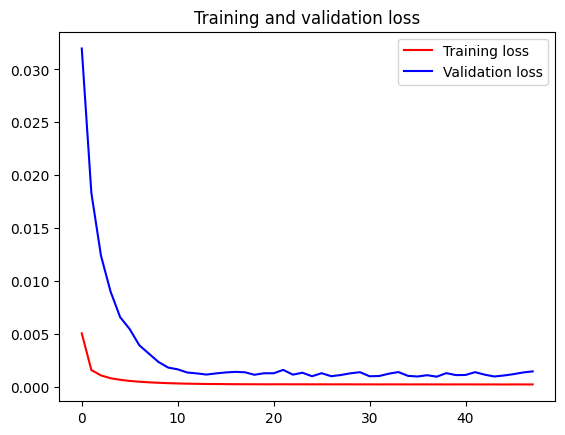

<Figure size 640x480 with 0 Axes>

In [71]:
#learning curves
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()

In [72]:
train_predict=m.predict(trainX)
val_predict=m.predict(valX)
test_predict=m.predict(testX)
train_predict.shape, val_predict.shape, test_predict.shape

15/15 [==============================] - 0s 6ms/step


((3864, 15, 1), (469, 15, 1), (469, 15, 1))

In [73]:
# Transform back to original form
train_predict = scalar.inverse_transform(train_predict)
test_predict = scalar.inverse_transform(test_predict)
val_predict = scalar.inverse_transform(val_predict)
original_ytrain = scalar.inverse_transform(train_y.reshape(-1,1)) 
original_ytest = scalar.inverse_transform(test_y.reshape(-1,1))
original_yval = scalar.inverse_transform(val_y.reshape(-1,1))

ValueError: Found array with dim 3. None expected <= 2.

In [ ]:
look_back=time_step
trainPredictPlot = np.empty_like(goo)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)